In [1]:
import pandas as pd
import os
import subprocess
from typing import List, Dict, Tuple

In [2]:
def set_working_dir():
    current_dir = os.getcwd()
    git_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"], cwd=current_dir)
    git_root = git_root.decode("utf-8").strip()
    os.chdir(git_root)
    new_dir = os.getcwd()
    return new_dir

working_dir = set_working_dir()
working_dir

data_dir = os.path.join(working_dir, "data/hka-aqm-n")

def load_dat_file(fpath):
    df = pd.read_csv(fpath, sep=";", skiprows=1)
    df["date_time"] = pd.to_datetime(df["date_time"])
    return df

# Load the data
file_list = os.listdir(data_dir)

In [3]:
df_all_rooms = pd.DataFrame()
for file in file_list:
    if file.endswith(".dat"):
        try:
            fpath = os.path.join(data_dir, file)
            df_room = load_dat_file(fpath)
            df_all_rooms = pd.concat([df_all_rooms, df_room])
        except Exception as e:
            print(f"Error loading file {file}: {e}")
            continue

Error loading file hka-aqm-n005_2022_05_17.dat: Error tokenizing data. C error: Expected 16 fields in line 110, saw 18



In [4]:
df_all_rooms.date_time.min(), df_all_rooms.date_time.max()

(Timestamp('2022-03-31 16:44:18'), Timestamp('2023-09-26 23:50:12'))

In [5]:
df_all_rooms.tmp.min(), df_all_rooms.tmp.max()

(0.0, 614.42)

In [6]:
df_all_rooms = df_all_rooms[(df_all_rooms.tmp <= 50) & (df_all_rooms.tmp >= -20)]
df_all_rooms = df_all_rooms[(df_all_rooms.hum <= 100) & (df_all_rooms.hum >= 0)]

In [7]:
def remove_whitespace(s):
    return s.strip()

df_all_rooms["device_id"] = df_all_rooms["device_id"].apply(remove_whitespace)

def extract_room(device_id):
    room = int(device_id.replace("hka-aqm-n", ""))
    return room

def extract_floor(device_id):
    floor = int(device_id.replace("hka-aqm-n", "")[0])
    return floor

df_all_rooms['room'] = df_all_rooms['device_id'].apply(extract_room)
df_all_rooms['floor'] = df_all_rooms['device_id'].apply(extract_floor)

In [8]:
df_all_rooms.shape

(282013, 20)

In [3]:
import dirs
working_dir = dirs.set_working_dir()
data_dir = os.path.join(working_dir, "data")
output_fpath = os.path.join(working_dir, "data/output.parquet")

In [4]:
df = pd.read_parquet(output_fpath)

In [5]:
df[(df.date_time.dt.date == pd.Timestamp("2023-04-18")) & (df.floor == 0)].room.unique()

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


array(['002', '003', '004', '009', '007', '012'], dtype=object)

In [6]:
df_214 = df[df.room == '214'].date_time.dt.date.unique()
date_range = pd.date_range(start=df_214.min(), end=df_214.max())
len(df_214)

236

In [7]:
[d for d in date_range.to_list() if d not in (df_214)][:5]

/var/folders/4v/7n25rgnx2zz8qd1csgnh63vw0000gn/T/ipykernel_27457/541253283.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  [d for d in date_range.to_list() if d not in (df_214)][:5]


[Timestamp('2022-09-27 00:00:00', freq='D'),
 Timestamp('2022-10-08 00:00:00', freq='D'),
 Timestamp('2022-10-09 00:00:00', freq='D'),
 Timestamp('2022-10-10 00:00:00', freq='D'),
 Timestamp('2022-10-11 00:00:00', freq='D')]

/opt/anaconda3/lib/python3.9/site-packages/calplot/calplot.py:313: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=len(years), ncols=1, squeeze=False,


ValueError: zero-size array to reduction operation minimum which has no identity

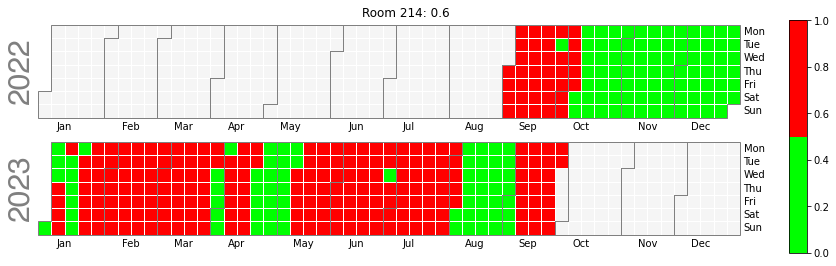

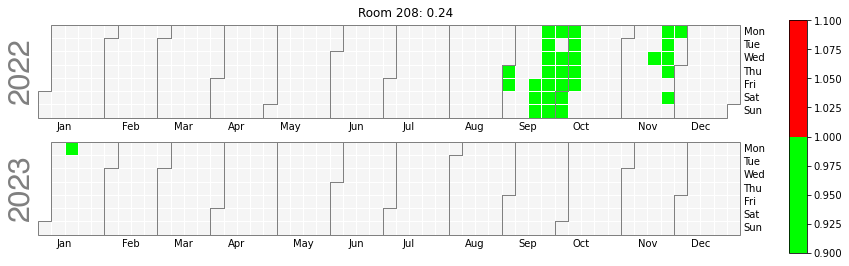

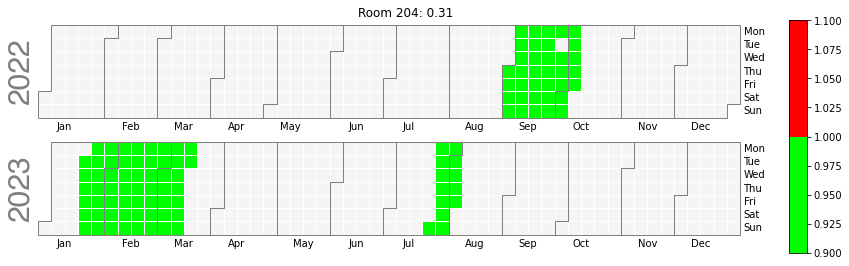

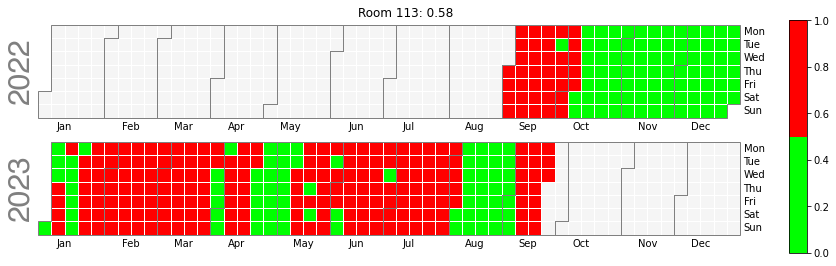

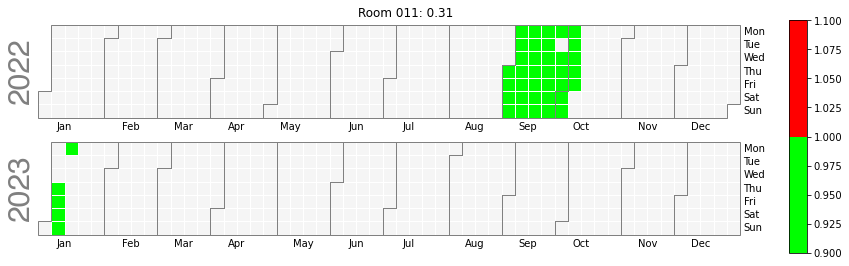

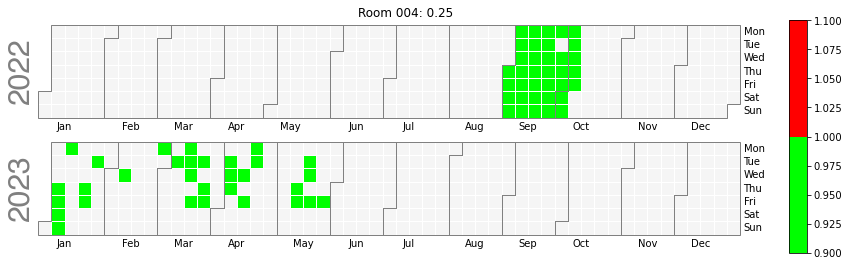

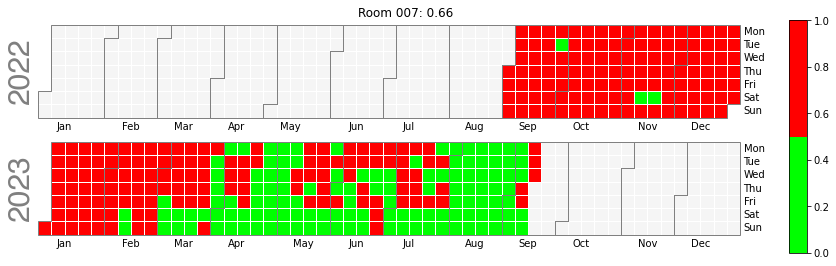

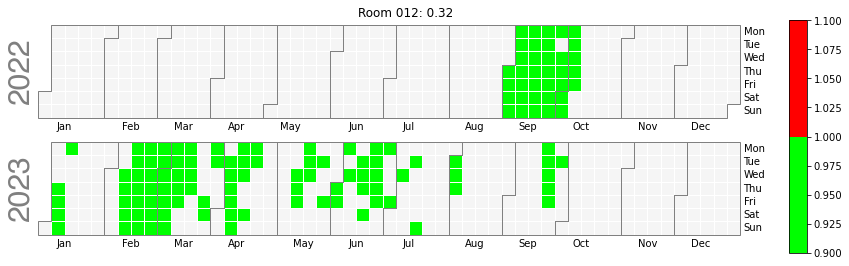

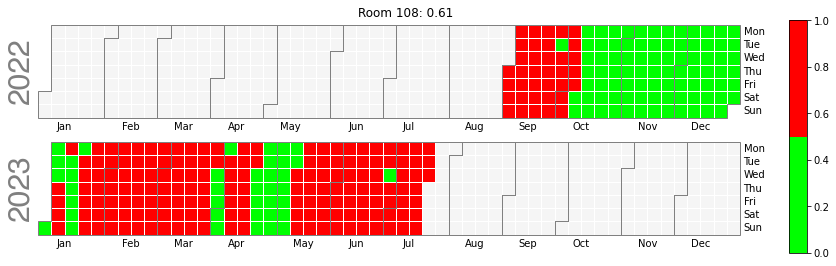

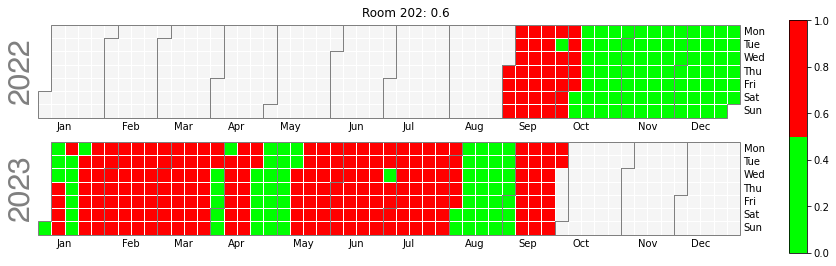

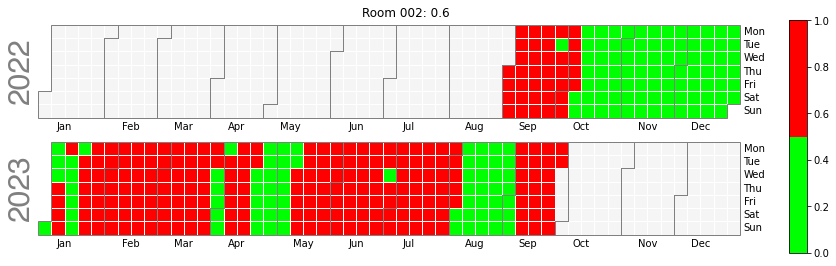

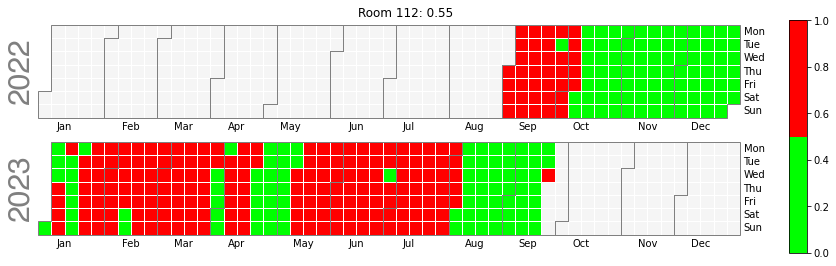

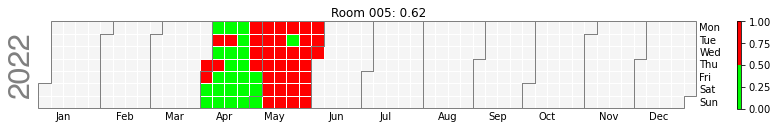

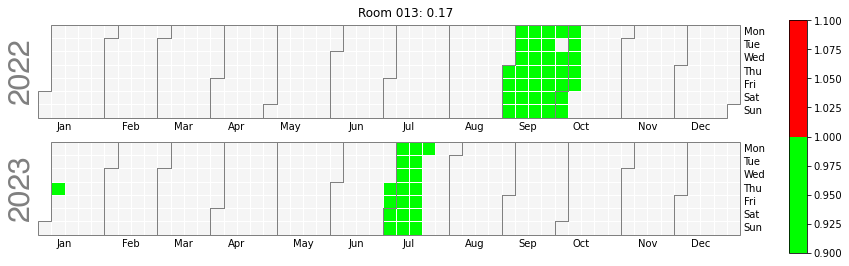

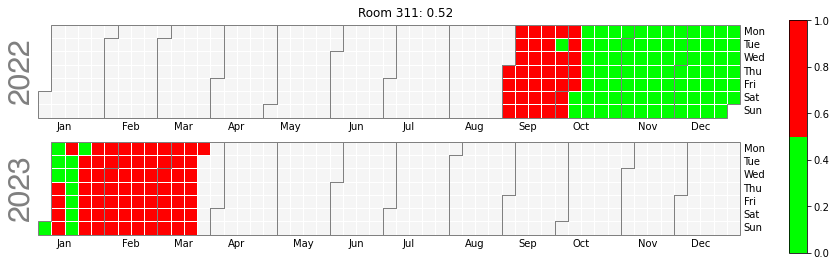

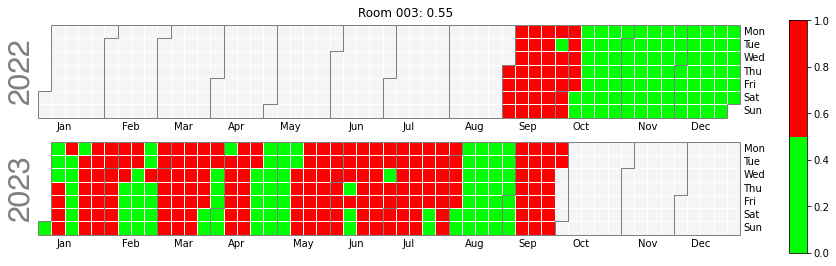

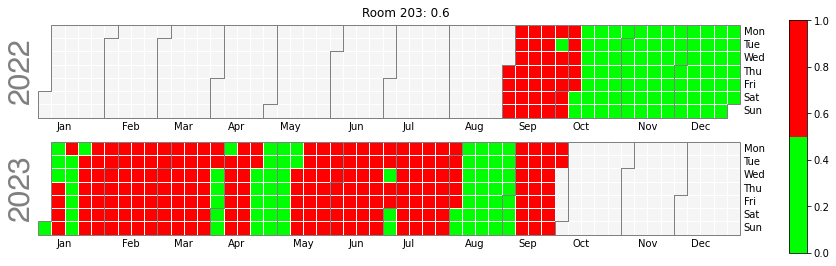

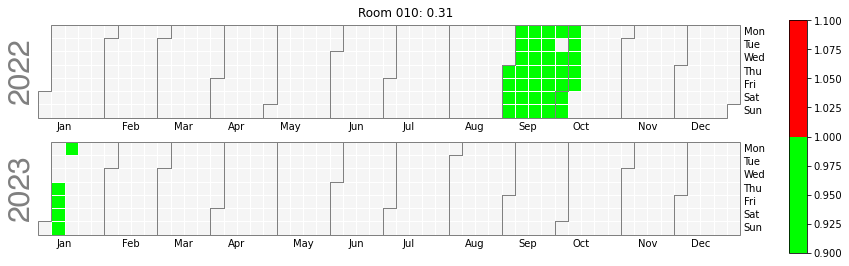

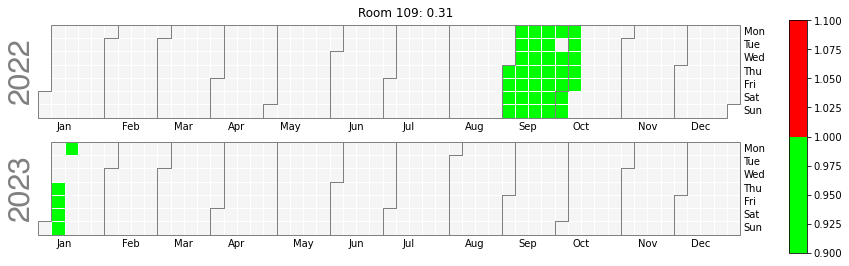

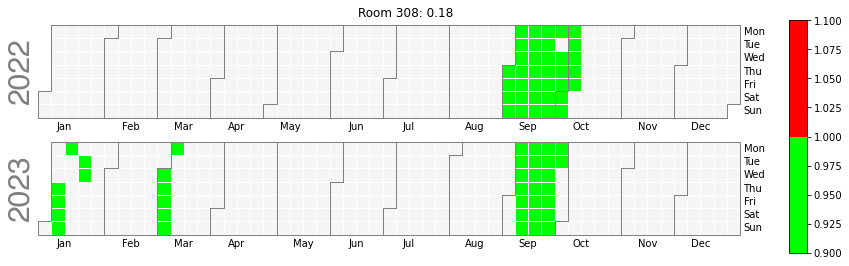

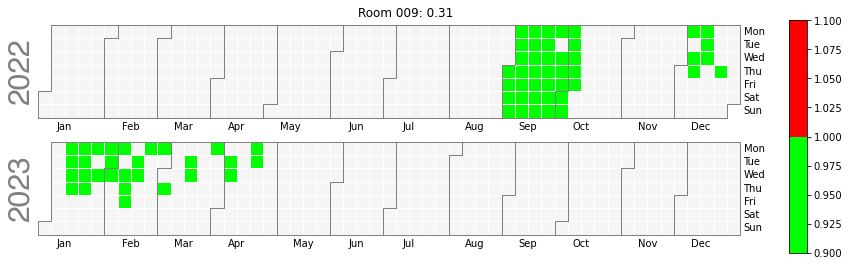

In [46]:
import calplot
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

# Zweifarbige Farbkarte: Grün für 0, Rot für 1
cmap = mcolors.ListedColormap(['#00ff00', '#ff0000'])

for room in df.room.unique():
    if room != "214":
        pass
    df_214 = df[df.room == room].date_time.dt.date.unique()
    date_range = pd.date_range(start=df_214.min(), end=df_214.max())

    # Dateninitialisierung
    cal_data = pd.Series(0, index=date_range)
    cal_data[pd.to_datetime(df_214)] = 1
    print(cal_data.max(), cal_data.min(), len(cal_data))
    # Plot mit der zweifarbigen Farbkarte
    calplot.calplot(cal_data, cmap=cmap, suptitle=f"Room {room}: {round(len(df_214)/len(date_range), 2)}")


In [43]:
cal_data[cal_data == 0]

2022-09-27    0
2022-10-08    0
2022-10-09    0
2022-10-10    0
2022-10-11    0
             ..
2023-08-30    0
2023-08-31    0
2023-09-01    0
2023-09-02    0
2023-09-03    0
Name: cal_data, Length: 155, dtype: int64